In [1]:
from shephard.apis import fasta
from shephard import interfaces
import metapredict as meta
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31
font = {'family' : 'arial', 'weight' : 'normal'}

matplotlib.rc('font', **font)


# note - sparrow is not yet public but we're leaving this in here because it
# avoids the need to re-write all the code to address the fact we're using an
# unpublished package...
# 
from sparrow import Protein

from sparrow.data.amino_acids import VALID_AMINO_ACIDS

from shephard.tools import domain_tools
from shephard.apis import uniprot
from shephard import interfaces, Proteome
from shephard.tools.sequence_tools import build_mega_string

In [2]:
# Read the FASTA file into a SHEPHARD proteome
TFs = Proteome([])
interfaces.si_proteins.add_proteins_from_file(TFs,'data/filtered/proteins.tsv')
interfaces.si_domains.add_domains_from_file(TFs,'data/filtered/shprd_IDRs.tsv')
interfaces.si_tracks.add_tracks_from_file(TFs,'data/filtered/shprd_tracks.tsv', mode='values')


### Data dictionaries
Build sorted dictionaries that map between the uid (Uniprot ID) and the data for activity or intensity. Note we have to cast these to float because after reading in from the `proteins.tsv` file protein attributes are all str type. This feels like something we should fix in later versions of SHEPHARD...

In [3]:
uid_to_activity = {}
uid_to_intensity = {}
for protein in TFs:
    uid = protein.unique_ID
    uid_to_activity[uid] = float(protein.attribute('activity'))
    uid_to_intensity[uid] = float(protein.attribute('intensity'))

# finally sort based on acitivty and intensity values    
uid_to_intensity = {k: v for k, v in sorted(uid_to_intensity.items(), key=lambda item: item[1])}        
uid_to_activity = {k: v for k, v in sorted(uid_to_activity.items(), key=lambda item: item[1])}        

# extract ordered uniprot IDs from the dictionary = this is the order we'll use
# for analysis
intensity_idx = list(uid_to_intensity.keys())
activity_idx = list(uid_to_activity.keys())    

## Run analysis
Cell below contains a key toggle-switch selector `mode` which must be one of `intensity` or `activity` and performs parameter analysis accordingly. The code ultimately generates three figures which are written to the `raw_figures/` directory.

In [14]:
## KEY VARIABLES

mode = 'intensity'

In [15]:

# define variables based on the passed mode
if mode == 'intensity':
    used_idx = intensity_idx
    used_dict = uid_to_intensity
    raw_data = list(used_dict.values())

elif mode == 'activity':
    used_idx = activity_idx
    used_dict = uid_to_activity
    raw_data = list(used_dict.values())
else:
    raise Exception('Invalid mode provided')
    
# initialize
all_annotations = []


# cycle over each UID
for i in used_idx:

    # empty list will hold parameters calculated for this sequence
    local = []
    
    # build a sparrow Protein object
    protein = Protein(build_mega_string(TFs.protein(i).domains))

    # first parameter is length
    local.append(len(protein))
    
    # next parameters (1-20) are amino acid fractions
    for AA in VALID_AMINO_ACIDS:
        local.append(protein.amino_acid_fractions[AA])
        
    # then (21-27) are additional specific parameters of interest
    local.append(protein.complexity)
    local.append(protein.FCR)
    local.append(protein.NCPR)
    local.append(protein.kappa)
    local.append(protein.hydrophobicity)
    local.append(protein.sequence.count('Y') + protein.sequence.count('F') + protein.sequence.count('W'))
    local.append(protein.sequence.count('Y') + protein.sequence.count('F') + protein.sequence.count('W') + protein.sequence.count('R'))
    
    # finally 28-47 are the length for low-complexity sequences composed of each of the 20 AAs using a 
    # pretty permissive criterion for LCS
    for AA in VALID_AMINO_ACIDS:
        LCS = protein.low_complexity_domains(residue_selector=AA, minimum_length=6,max_interruption=2)
        v = 1
        local.append(v+np.sum([len(x[0]) for x in LCS]))

    # finally, add the local list to the all_annotations list and repeat
    all_annotations.append(local)

## Here we define the names of all the params above
# We have to MANUALLY make sure these match our order and type of analysis or this will cause issues
names = []
names.append('length')
names.extend(VALID_AMINO_ACIDS.copy())
names.append('Complexity')
names.append('FCR')
names.append('NCPR')
names.append('kappa')
names.append('hydro')
names.append('aro count')
names.append('aro+arg count')
for aa in VALID_AMINO_ACIDS:
    names.append(f"{aa}_LCS")


## Finally we normalize so thay EACH parameter falls in the interval between 0 and 1, so we can
# plot all parameters on the same scale. Effectively, this normalization enables rank ordering of
# each parameter for each sequence

# build normalized array
tmp_normalized = []
idx = 0
for v in np.array(all_annotations).transpose():
    idx=idx+1
    val = np.nan_to_num((v - np.min(v))/(np.max(v) - np.min(v)), 0)
    
    tmp_normalized.append(val)
    
normalized = np.array(tmp_normalized).transpose()    
    
    
    
    

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_37242/2141448311.py:78: RuntimeWarning: invalid value encountered in true_divide
  val = np.nan_to_num((v - np.min(v))/(np.max(v) - np.min(v)), 0)


### Do we see correlations between params and data
Use simple Pearson's regression; this is simplistic but is meant to give general trends. If we wanted to be rigerous should bootstrap to get a sense of how strongly specific values determine correlations.

In [16]:
name2corr = {}

idx = 0
for v in normalized.transpose():
    name2corr[names[idx]] =np.corrcoef(raw_data, v)[0][1]
    idx = idx + 1


### Make figures
Finally make figures that show relationship between parameters and data

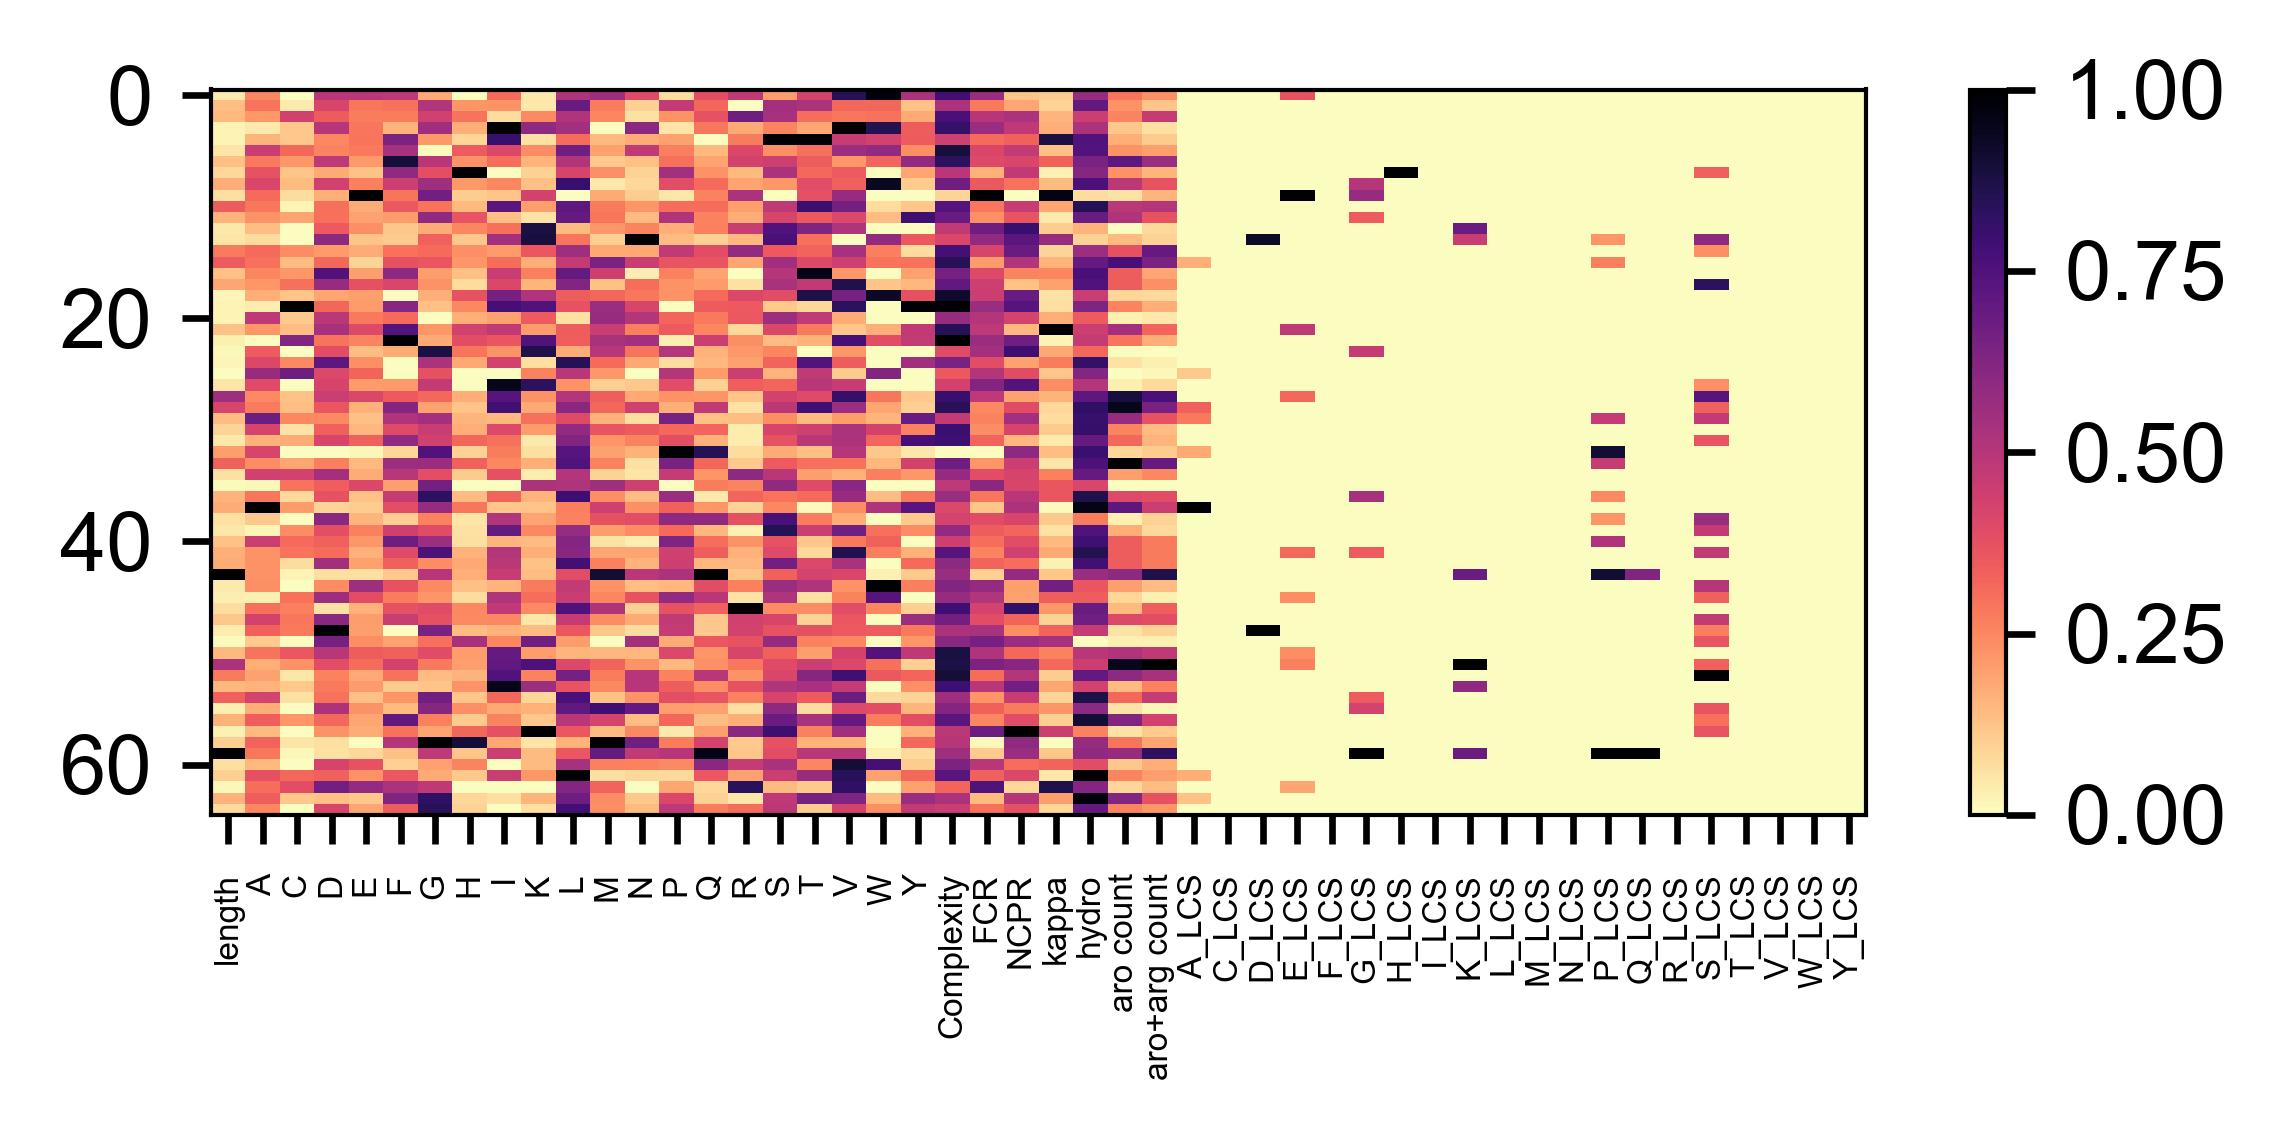

In [17]:
figure(num=None, figsize=(4, 2), dpi=300, facecolor='w', edgecolor='k')
plt.imshow(np.array(normalized),aspect='auto',cmap='magma_r')    
plt.xticks(np.arange(0,len(names)), names, fontsize=4, rotation=90)
#plt.yticks(np.arange(0,20), VALID_AMINO_ACIDS, fontsize=7)
plt.colorbar()
print('')
plt.tight_layout()
plt.savefig(f'raw_figures/{mode}_headmap.pdf')



<Figure size 1200x300 with 0 Axes>

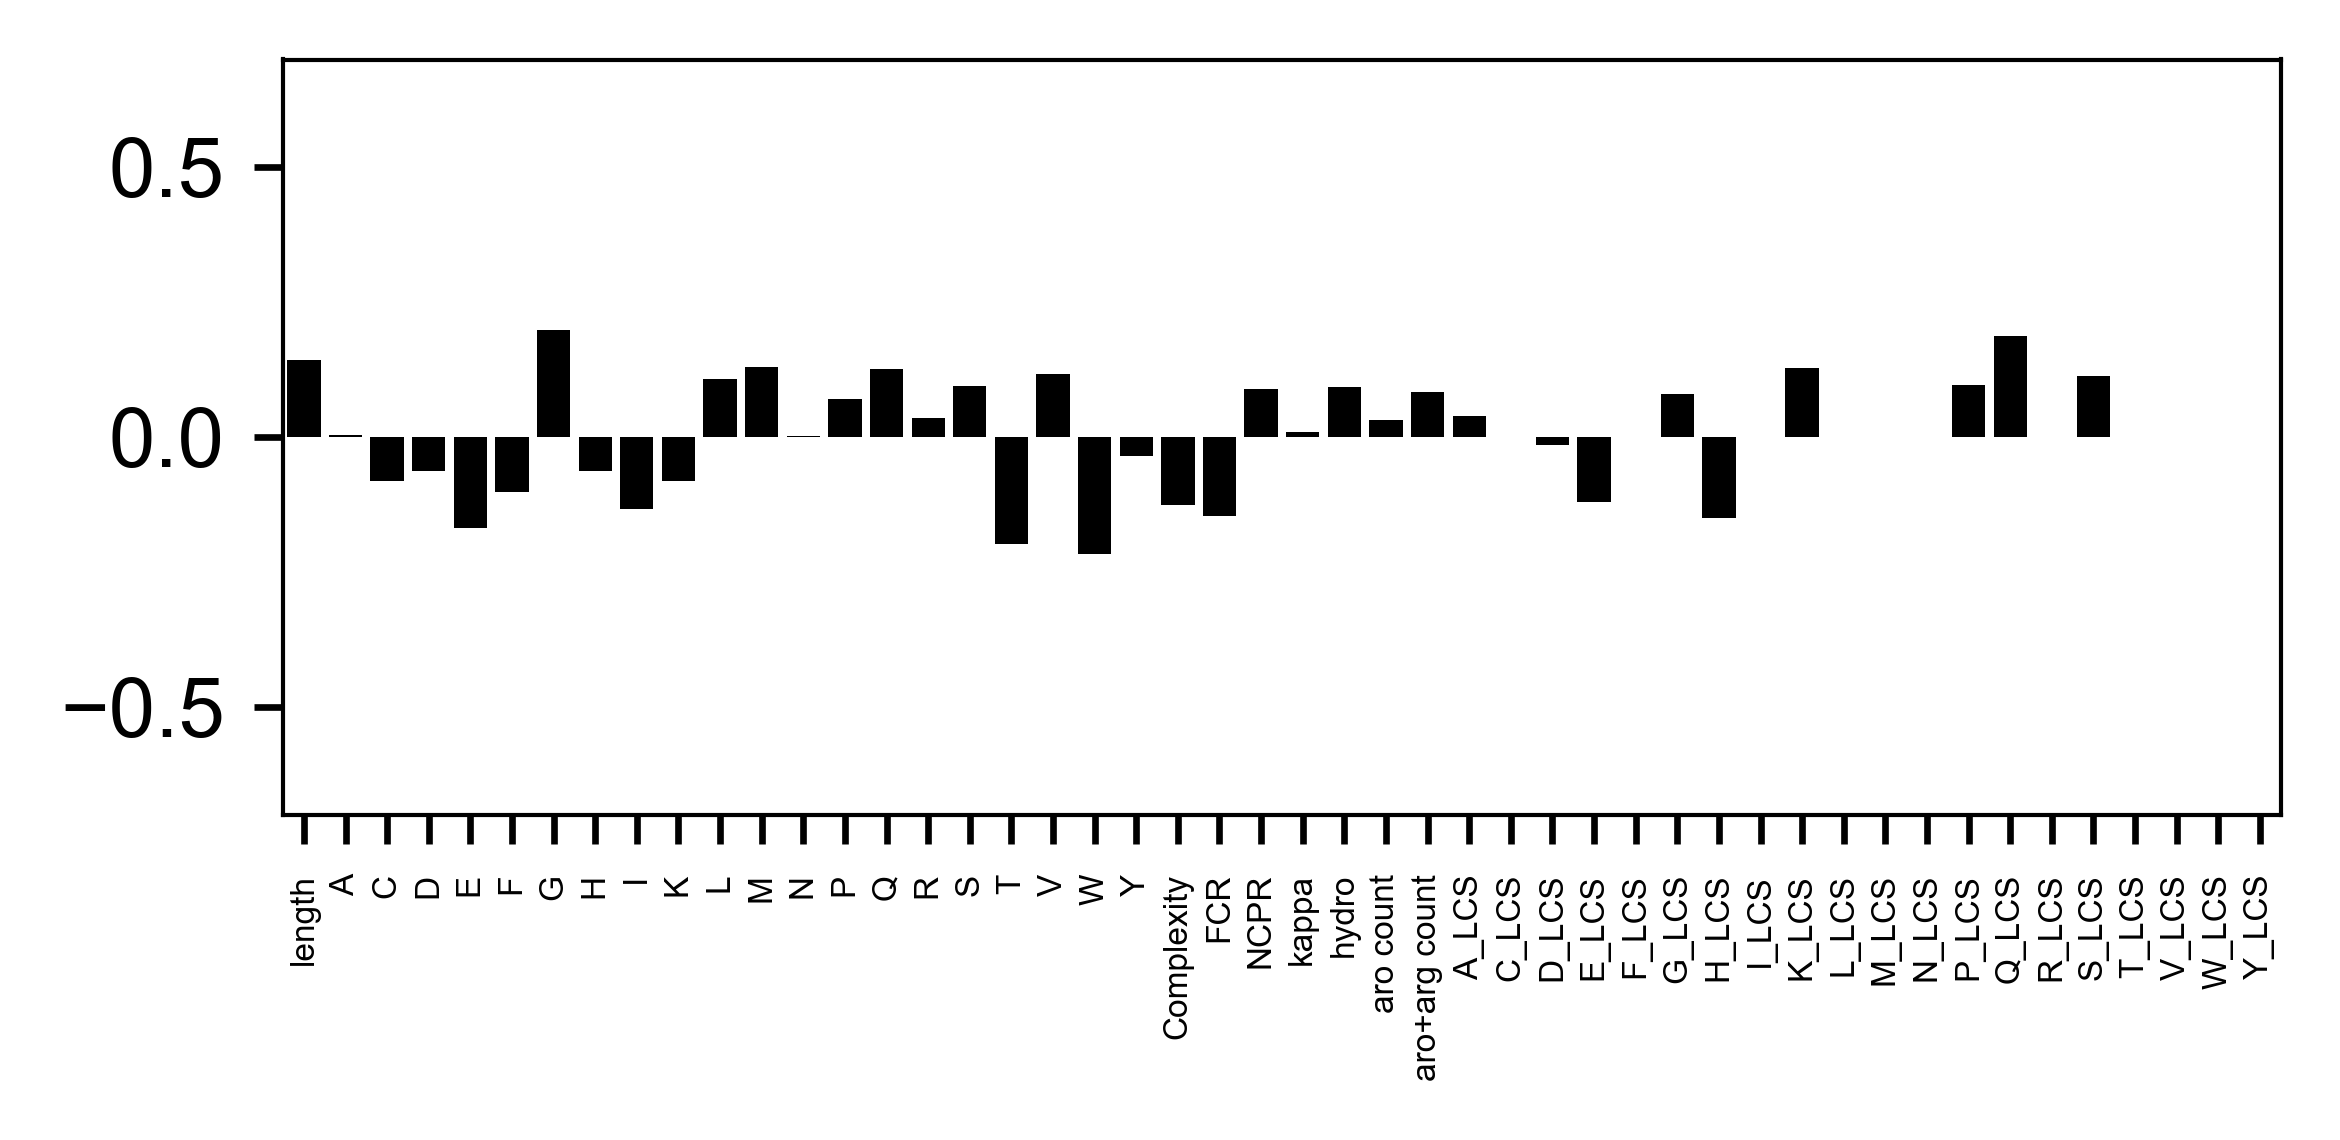

In [18]:
corvals = list(name2corr.values())
figure(num=None, figsize=(4, 1), dpi=300, facecolor='w', edgecolor='k')
figure(num=None, figsize=(4, 2), dpi=300, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,len(corvals)), corvals, color='k',width=0.8)
plt.xlim([-0.5,len(corvals)-0.5])
plt.ylim([-0.7,0.7])
plt.xticks(np.arange(0,len(names)), names, fontsize=4, rotation=90)
print('')
plt.tight_layout()
plt.savefig(f'raw_figures/{mode}_correlations.pdf')


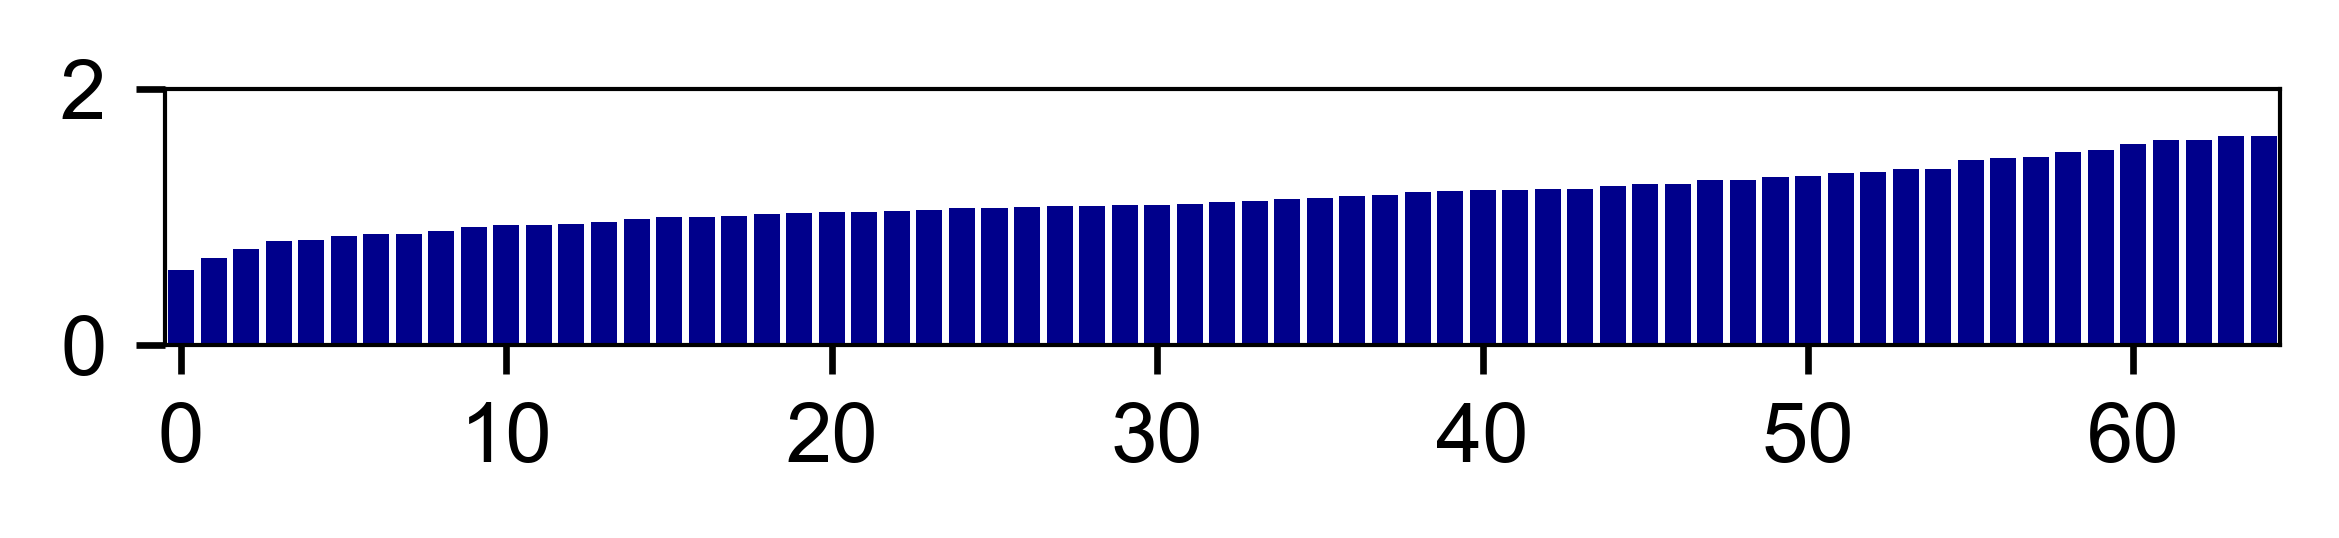

In [19]:
corvals = list(name2corr.values())
figure(num=None, figsize=(4, 1), dpi=300, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,len(raw_data)), raw_data, color='darkblue',width=0.8)
plt.xlim([-0.5,len(raw_data)-0.5])

if mode == 'intensity':
    plt.ylim([0,2])
else:
    plt.ylim([0,3.5])

print('')
plt.tight_layout()
plt.savefig(f'raw_figures/{mode}_data.pdf')


### FINALLY write out data
To ensure data are not trapped in this notebook all data are written to file

In [20]:
with open('shared_data/column_names.txt','w') as fh:
    for c in names:
        fh.write(f"{c}\n")

In [21]:
with open(f'shared_data/{mode}_gene_names.txt','w') as fh:
    for c in [TFs.protein(k).attribute('gene_name') for k in used_idx]:
        fh.write(f"{c}\n")

In [22]:
fn = f'shared_data/{mode}_raw_parameters.txt'
np.savetxt(fn, np.array(all_annotations), fmt='%1.5f', delimiter=', ')

fn = f'shared_data/{mode}_norm_parameters.txt'
np.savetxt(fn, np.array(normalized), fmt='%1.5f', delimiter=', ')